# Clasificación con data de _Employee_

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-employee")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

Se verifica en el Spark Master que se esté corriendo la aplicación "pyspark-employee"
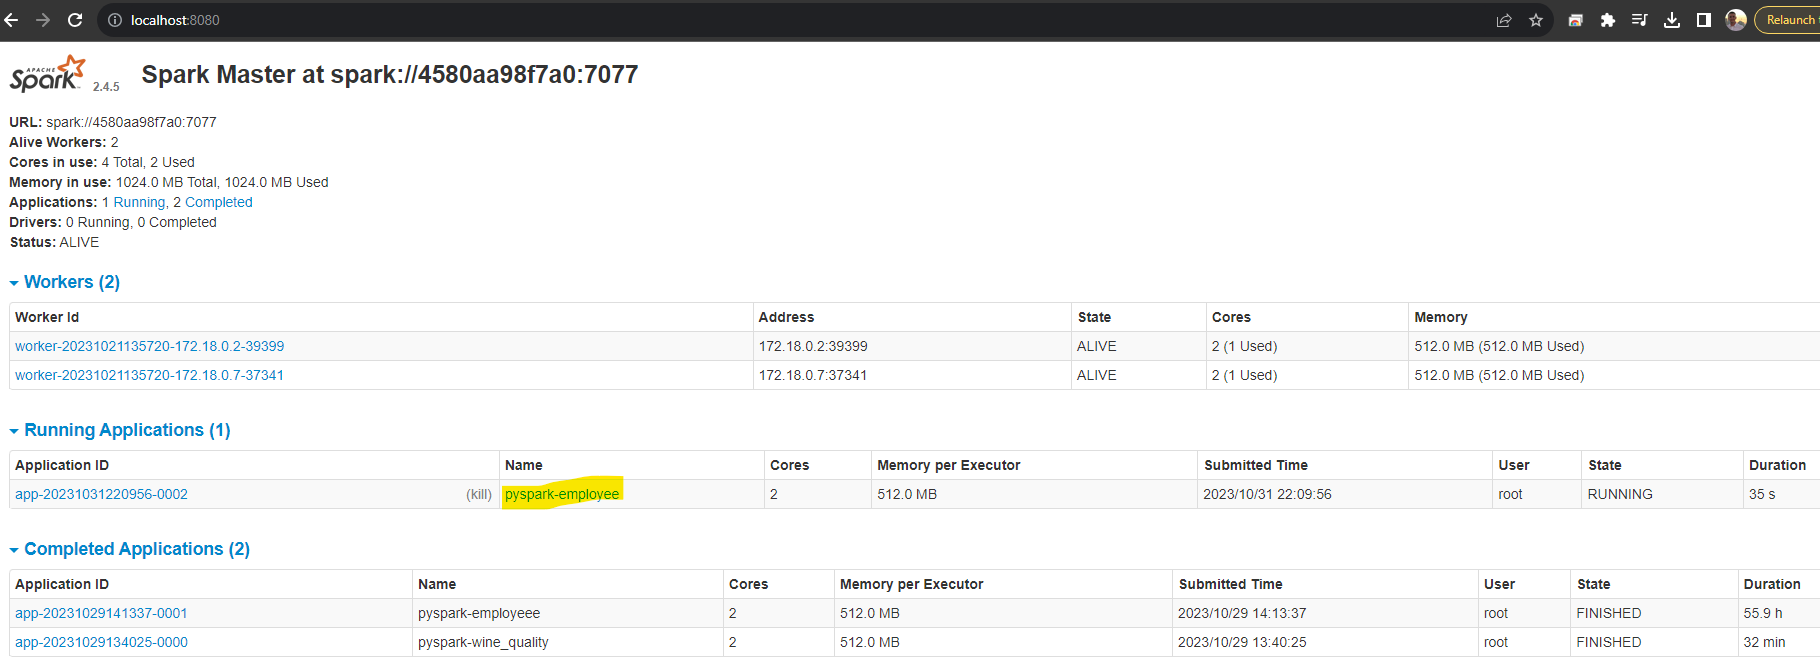

In [3]:
spark.version

'2.4.5'

En este punto, debe prestarse suma atención al tipo de dato que se le asigna a los datos (valga la redundancia). Por ejemplo, notar que a "Age" la define con el tipo "string", y debería ser un "integer".  
Por otro lado, el archivo _csv_ , vive en la computadora local, y está mapeado al volumen de Docker para que lo levante aquí (es decir, el contenedor está viendo el volumen mapeado).


In [4]:
dft = spark.read.csv('/dataset/Employee.csv', header=True)

In [5]:
dft.show(10)

+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+
|Education|JoiningYear|     City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|LeaveOrNot|
+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+
|Bachelors|       2017|Bangalore|          3| 34|  Male|         No|                        0|         0|
|Bachelors|       2013|     Pune|          1| 28|Female|         No|                        3|         1|
|Bachelors|       2014|New Delhi|          3| 38|Female|         No|                        2|         0|
|  Masters|       2016|Bangalore|          3| 27|  Male|         No|                        5|         1|
|  Masters|       2017|     Pune|          3| 24|  Male|        Yes|                        2|         1|
|Bachelors|       2016|Bangalore|          3| 22|  Male|         No|                        0|         0|
|Bachelors|       2015|New Delhi|          3| 

Se imprime el esquema, a fin de que pueda notarse si es necesario realizar algún casteo de tipos. A su vez, se puede identificar la variable "LeaveOrNot" etiquetada, que indicaría si el empleado se va o permanece en la Empresa: 

In [6]:
dft.printSchema()

root
 |-- Education: string (nullable = true)
 |-- JoiningYear: string (nullable = true)
 |-- City: string (nullable = true)
 |-- PaymentTier: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EverBenched: string (nullable = true)
 |-- ExperienceInCurrentDomain: string (nullable = true)
 |-- LeaveOrNot: string (nullable = true)



In [7]:
from pyspark.sql.types import DoubleType, IntegerType

A continuación, tomo la columna _'LeaveOrNot'_ , y se castea como un entero. Luego, se vuelve a colocar en dft, que era donde se había levantado el dataset:

In [8]:
dft = dft.withColumn('LeaveOrNot', dft['LeaveOrNot'].cast(IntegerType()))

Se imprime nuevamente el esquema, a fin de ver cómo quedó configurada la variable _'LeaveOrNot'_ :

In [9]:
dft.printSchema()

root
 |-- Education: string (nullable = true)
 |-- JoiningYear: string (nullable = true)
 |-- City: string (nullable = true)
 |-- PaymentTier: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EverBenched: string (nullable = true)
 |-- ExperienceInCurrentDomain: string (nullable = true)
 |-- LeaveOrNot: integer (nullable = true)



In [10]:
dft.select('LeaveOrNot').show(5)

+----------+
|LeaveOrNot|
+----------+
|         0|
|         1|
|         0|
|         1|
|         1|
+----------+
only showing top 5 rows



Es importante identificar en un problema de clasificación, el __"Balanceo de Clases"__ . Para ello, se realiza un _group by_ sobre el target:

In [11]:
dft.groupBy('LeaveOrNot').count().orderBy('count').show(10)

+----------+-----+
|LeaveOrNot|count|
+----------+-----+
|         1| 1600|
|         0| 3053|
+----------+-----+



Puede decirse que está medianamente balanceado.  
Luego, se cuentan la cantidad de registros:

In [12]:
dft.count()

4653

## Extraccion de datos

Lógica de CACHÉ: 
La segunda vez que llama a la función, en vez de ir a buscar de nuevo los datos a la URL, o a una BdD o una API, lo levanta de lo que esté cacheado. 

In [13]:
from pathlib import Path
import pandas as pd

Se define la función "extract_employee_data", que le "pega" a la URL y la guarda en la caché (si es que aún no lo estaba):

In [14]:
def extract_employee_data(url, refresh_cache=False):
    cache_fn = Path('/dataset/Employee.csv')
    if not cache_fn.exists() or refresh_cache:
        print("Getting data")
        df = pd.read_csv(url) #Aquí le pego a la URL
        df.to_csv(cache_fn, index=False)
    print("Using cache") #caso entroario, entra a lo "cacheado"
    df = spark.read.csv(str(cache_fn), header=True)
    return df

In [15]:
url = 'https://gist.githubusercontent.com/mauroRot/f87dd642527d2a43d7f493ef1f484b5e/raw/cae9eb1e03731a6e6a1c26300389a576e28614e6/Employee.csv'


In [16]:
df_raw = extract_employee_data(url)

Using cache


In [17]:
type(df_raw)

pyspark.sql.dataframe.DataFrame

In [18]:
df_raw.show(10)

+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+
|Education|JoiningYear|     City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|LeaveOrNot|
+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+
|Bachelors|       2017|Bangalore|          3| 34|  Male|         No|                        0|         0|
|Bachelors|       2013|     Pune|          1| 28|Female|         No|                        3|         1|
|Bachelors|       2014|New Delhi|          3| 38|Female|         No|                        2|         0|
|  Masters|       2016|Bangalore|          3| 27|  Male|         No|                        5|         1|
|  Masters|       2017|     Pune|          3| 24|  Male|        Yes|                        2|         1|
|Bachelors|       2016|Bangalore|          3| 22|  Male|         No|                        0|         0|
|Bachelors|       2015|New Delhi|          3| 

In [19]:
df_raw.printSchema() #muestro el esquema

root
 |-- Education: string (nullable = true)
 |-- JoiningYear: string (nullable = true)
 |-- City: string (nullable = true)
 |-- PaymentTier: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EverBenched: string (nullable = true)
 |-- ExperienceInCurrentDomain: string (nullable = true)
 |-- LeaveOrNot: string (nullable = true)



In [20]:
df_raw.count()

4653

Se parte el conjunto de datos de forma aleatoria en dos en un conjunto de __train__ y otro de __test__ , de manera tal que el primero tenga el 70% de los registros:

In [21]:
# Train/test split
train_df, test_df = df_raw.randomSplit([0.7,0.3],seed=1234)

In [22]:
df_raw.randomSplit?

In [23]:
#Chequeo la cantidad de registros que quedaron en "train"
train_df.count()

3298

De querer hacerlo de otra forma:

In [24]:
from pyspark.sql.functions import rand, when
df_raw = df_raw.withColumn('train', when(rand(seed=1234) > 0.3, True).otherwise(False))

In [25]:
rand?

In [26]:
df_raw.select('train').groupby('train').count().show()

+-----+-----+
|train|count|
+-----+-----+
| true| 3235|
|false| 1418|
+-----+-----+



In [27]:
df_raw.select('train').printSchema()

root
 |-- train: boolean (nullable = false)



In [28]:
import pyspark.sql.functions as f

In [29]:
df_train = df_raw.filter(f.col('train') == True)

In [30]:
df_train.count()

3235

In [31]:
df_test = df_raw.filter(f.col('train') != True)

In [32]:
df_test.count()

1418

## EDA

In [33]:
# Casteo de datos
df_raw.printSchema()

root
 |-- Education: string (nullable = true)
 |-- JoiningYear: string (nullable = true)
 |-- City: string (nullable = true)
 |-- PaymentTier: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EverBenched: string (nullable = true)
 |-- ExperienceInCurrentDomain: string (nullable = true)
 |-- LeaveOrNot: string (nullable = true)
 |-- train: boolean (nullable = false)



La función que sigue, recibe el df, y para cada columna, la castea con el nuevo tipo:

In [34]:
def cast_cols(df, cols, new_type):
  for col in cols: 
     df = df.withColumn(col, df[col].cast(new_type()))
  return df

Defino de las columnas que correspondan, cuáles serán del tipo entero (no hay del tipo float para este caso, se deja esa línea de cógigo comentado:

In [35]:
integer_cols = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain', 'LeaveOrNot']
#float_cols = ['unaColumna', 'otraColumna']

In [36]:
df_raw = cast_cols(df_raw, integer_cols, IntegerType)
#df_raw = cast_cols(df_raw, float_cols, DoubleType)

In [37]:
df_raw.printSchema()

root
 |-- Education: string (nullable = true)
 |-- JoiningYear: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- PaymentTier: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EverBenched: string (nullable = true)
 |-- ExperienceInCurrentDomain: integer (nullable = true)
 |-- LeaveOrNot: integer (nullable = true)
 |-- train: boolean (nullable = false)



## Loggear el flujo de eventos

Esto es importante porque uno puede sin querer, cometer errores. 
Es clave la trazabilidad en este punto. 

In [38]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s-%(name)s-%(levelname)s: %(message)s',
    handlers=[logging.FileHandler('/dataset/titanic_spark.log'), logging.StreamHandler()],
)
logger = logging.getLogger(__name__)

La siguiente función, descarta las columnas que NO van a utilizarse en el dataset, quedando todo esto loggeado:



In [39]:
def _drop_unusable_cols(df, cols=[]):
    logger.info(
        f"Dropping the following {len(cols)} unusable columns:\n"
        f"{cols}"
    )
    df = df.drop(*cols)
    logger.info(
        f"Remaining {len(df.columns)} columns:\n {sorted(df.columns)}"
    )
    return df

Lo que se pretende mostrar en las lineas que siguen, es que conviene droppear las columnas sobre el dataset entero, y después dividir en train y test con lo que quedó (lo hará al final de este ejercicio), y NO hacerlo en el de train, luego en el de test por separado... porque es propenso a cometer errores.  
  
En este dataset, no se droppeará ninguna columna. No obstante, se deja la línea de código para el train y el test comentadas (y NO las borro), porque es importante contemplar esta posibilidad en otro dataset.  

In [40]:
train_df = _drop_unusable_cols(train_df, cols=[])
#train_df = _drop_unusable_cols(train_df, cols=['boat', 'body', 'train'])

2023-10-31 23:39:04,948-__main__-INFO: Dropping the following 0 unusable columns:
[]
2023-10-31 23:39:04,959-__main__-INFO: Remaining 9 columns:
 ['Age', 'City', 'Education', 'EverBenched', 'ExperienceInCurrentDomain', 'Gender', 'JoiningYear', 'LeaveOrNot', 'PaymentTier']


In [41]:
train_df.columns, test_df.columns

(['Education',
  'JoiningYear',
  'City',
  'PaymentTier',
  'Age',
  'Gender',
  'EverBenched',
  'ExperienceInCurrentDomain',
  'LeaveOrNot'],
 ['Education',
  'JoiningYear',
  'City',
  'PaymentTier',
  'Age',
  'Gender',
  'EverBenched',
  'ExperienceInCurrentDomain',
  'LeaveOrNot'])

In [42]:
test_df = _drop_unusable_cols(test_df, cols=[])
#test_df = _drop_unusable_cols(test_df, cols=['boat', 'body', 'train'])

2023-10-31 23:39:08,475-__main__-INFO: Dropping the following 0 unusable columns:
[]
2023-10-31 23:39:08,482-__main__-INFO: Remaining 9 columns:
 ['Age', 'City', 'Education', 'EverBenched', 'ExperienceInCurrentDomain', 'Gender', 'JoiningYear', 'LeaveOrNot', 'PaymentTier']


In [43]:
train_df = train_df.withColumn('train_new', f.lit(True))
test_df = test_df.withColumn('train_new', f.lit(False))

Aquí solo se juntan para garantizar que no eliminó ningún registro, solo por eso:

In [44]:
joined_df = train_df.unionByName(test_df)
joined_df.count()

4653

In [45]:
df = _drop_unusable_cols(df_raw, cols=[])
#df = _drop_unusable_cols(df_raw, cols=['boat', 'body', 'ticket'])

2023-10-31 23:39:18,025-__main__-INFO: Dropping the following 0 unusable columns:
[]
2023-10-31 23:39:18,031-__main__-INFO: Remaining 10 columns:
 ['Age', 'City', 'Education', 'EverBenched', 'ExperienceInCurrentDomain', 'Gender', 'JoiningYear', 'LeaveOrNot', 'PaymentTier', 'train']


In [46]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
df.select('train').show(5)

+-----+
|train|
+-----+
| true|
| true|
| true|
| true|
| true|
+-----+
only showing top 5 rows



Las líneas de código, muestran en forma gráfica el balanceo de la columna _LeaveOrNot_ :  

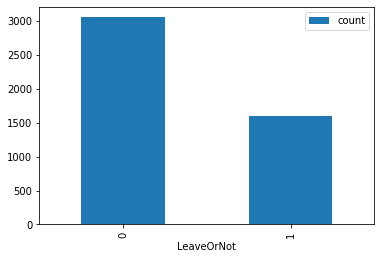

In [48]:
df.select('LeaveOrNot').groupBy('LeaveOrNot').count().toPandas().set_index('LeaveOrNot').plot.bar()

## EDA - Visualizaciones

A fin de entender qué es lo que sucede en el dataset, si hay relación entre variables y demás, se utilizará Seaborn para hacer algunas visualizaciones estadísticas, y particularmente con correlaciones lineales:

In [49]:
import seaborn as sns

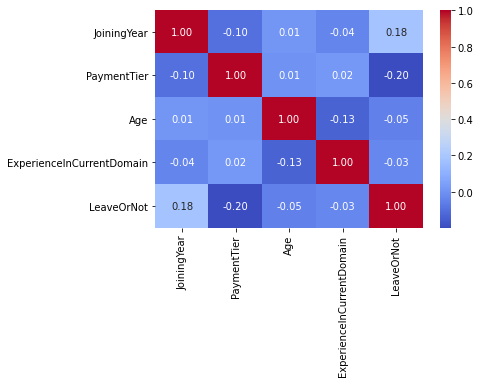

In [50]:
g = sns.heatmap(df.select('JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain', 'LeaveOrNot').toPandas().corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")

# el .2f hace mención a que grafique con 2 decimales

#### Reflexión
El gráfico anterior, permitiría vislumbrar cuáles de las variables tienen poca relación con la variable a predecir (LeaveOrNot). Por ejemplo, podría observarse que, _JoiningYear_ y _PaymentTier_ tendría una correlación con _LeaveOrNot_ , superior al resto de las involucradas.  En este caso, la variable "Age" no parece ser muy indicativa. Sin embargo, la Correlación de Pearson es lineal, y tal vez la relación que tenga "Age" con "LeaveOrNot" sea NO lineal, y si se la quita del análisis, estaría perdiendo poder en mi modelo de predicción.   
Además, la variable sola puede no tener poder predictivo, pero si se realiza una combinación lineal con las otras, quizás SI lo tenga.    
__En conclusión, NO es recomdable eliminar variables sino se tiene total certeza de su utilidad en la creación del modelo__ . Es por ello, que se toma la decisión de dejarla. 

Si se realiza un gráfico de distribución sobre "Age", condicionado al target _LeaveOrNot_ :

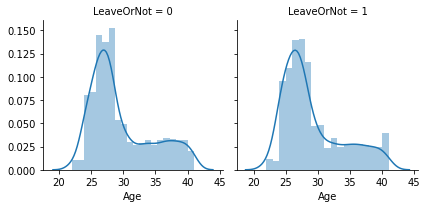

In [51]:
g = sns.FacetGrid(df.toPandas(), col='LeaveOrNot')
g = g.map(sns.distplot, 'Age')

A continuación, se crean dos funciones, para los dos valores que puede tomar _LeaveOrNot_ , y en donde el valor de _Age_ no es nulo: 

In [52]:
leave_age = df.filter((f.col('LeaveOrNot') == 1) & 
                         (f.col('Age').isNotNull())).select('Age').toPandas()
not_leave_age = df.filter((f.col('LeaveOrNot') == 0) & (f.col('Age').isNotNull())).select('age').toPandas()

In [53]:
leave_age.squeeze()

0       28
1       27
2       24
3       34
4       27
        ..
1595    28
1596    33
1597    32
1598    37
1599    27
Name: Age, Length: 1600, dtype: int32

In [54]:
type(leave_age.squeeze())

pandas.core.series.Series

Grafico la distribución de los que dejaron el trabajo y los que no:

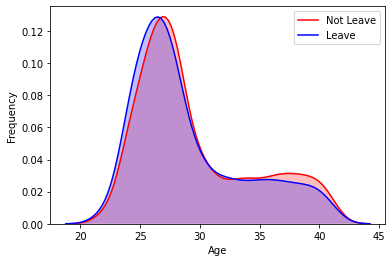

In [55]:
g = sns.kdeplot(not_leave_age.squeeze(), color='Red', shade=True)
g = sns.kdeplot(leave_age.squeeze(), color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Not Leave', 'Leave'])

#### Conclusiones del gráfico de distribución: 
En el rango de edades mayores a 35, es más probable que no dejen el trabajo a que sí lo hagan. 

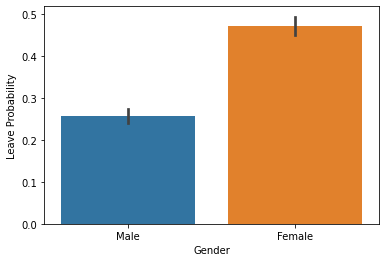

In [56]:
g = sns.barplot(x='Gender', y='LeaveOrNot', data=df.toPandas())
g = g.set_ylabel("Leave Probability")

Del gráfico anterior, hay mayor probabilidad de que las mujeres dejen el trabajo. 

In [57]:
df.select('Gender', 'LeaveOrNot').groupby('Gender').mean().show()

+------+-------------------+
|Gender|    avg(LeaveOrNot)|
+------+-------------------+
|Female|0.47146666666666665|
|  Male|  0.257739380849532|
+------+-------------------+



En el gráfico que sigue, se condiciona con otra variable más del dataset con motivo de detectar si había una relación entre la variable _PaymentTier_ , junto con las anteriormente graficadas _Gender_ y el target _LeaveOrNot_ :

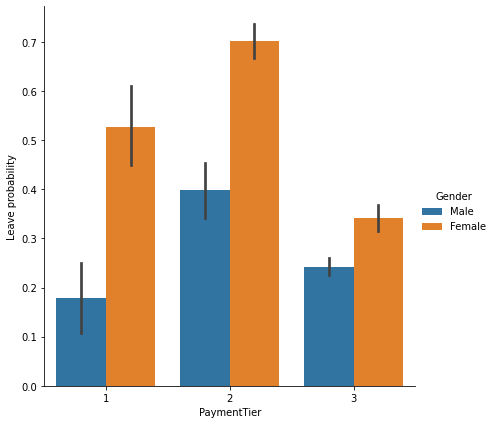

In [58]:
g = sns.catplot(x='PaymentTier', y='LeaveOrNot', hue='Gender', data=df.toPandas(),
                   height=6, kind='bar')
g = g.set_ylabels("Leave probability")

Como conclusión, independientemente de los niveles de escalas salariales, las mujeres suelen irse del trabajo. A su vez, puede apreciarse que para el nivel de _PaymentTier_ 3, la brecha comparado con los hombres que dejan el trabajo es menor que para los otros dos casos. Puede entenderse que esa escala salarial es la más alta, siendo más difícil que dejen el trabajo. 

## Valores nulos y constantes  


In [59]:
type(df)

pyspark.sql.dataframe.DataFrame

Se desea obtener una lógica de conteo de valores nulos. Para ello, la siguiente línea de código, toma una columna, chequea en cada uno de sus registros si alguno es nulo, y de serlo, se castea a un entero (tomando el valor 1), y se sumará el total de estos, para luego dividirlo por el total de registros de esa misma columa. De esta forma, puede conocerse, expresado en porcentaje, qué cantidad de valores nulos tiene.  

In [60]:
df_nulls = df.select([f.sum(f.col(c).isNull().cast('integer') / df.count()).alias(c) for c in df.columns])

In [61]:
df_nulls.show()

+---------+-----------+----+-----------+---+------+-----------+-------------------------+----------+-----+
|Education|JoiningYear|City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|LeaveOrNot|train|
+---------+-----------+----+-----------+---+------+-----------+-------------------------+----------+-----+
|      0.0|        0.0| 0.0|        0.0|0.0|   0.0|        0.0|                      0.0|       0.0|  0.0|
+---------+-----------+----+-----------+---+------+-----------+-------------------------+----------+-----+



Al ser todos los valores 0.0, se traduce a que el dataset no contiene nulos.  
  
Por otro lado, en caso de que existan valores nulos (para otro dataset), queda establecido un criterio en el que si una columna tiene más del 50% de sus valores nulos, se droppea. Queda esto comprendido en la siguiente función:

In [62]:
def _drop_nulls(df, max_null_prop=0.5):
    logger.info(
        f"Dropping columns with null ratio greater than {max_null_prop * 100}%..."
    )
    df_nulls = df.select([f.sum(f.col(c).isNull().cast('integer') / df.count()).alias(c) 
                          for c in df.columns])
    logger.info(f"Null proportions:\n {df_nulls.show()}")
    null_cols = [c for c in df_nulls.columns if df_nulls.select(c).first()[0] > max_null_prop 
                 and c not in PROTECTED_COLS]
    logger.info(f"Dropping the following {len(null_cols)} columns:\n {null_cols}")
    df = df.drop(*null_cols)
    return df

Lo que hay que contemplar, es que NO droppee la columna target _LeaveOrNot_ en ese caso, y la de entrenamiento _train_ :

In [63]:
PROTECTED_COLS = ['LeaveOrNot', 'train']
df = _drop_nulls(df)

2023-10-31 23:40:15,078-__main__-INFO: Dropping columns with null ratio greater than 50.0%...
2023-10-31 23:40:16,429-__main__-INFO: Null proportions:
 None


+---------+-----------+----+-----------+---+------+-----------+-------------------------+----------+-----+
|Education|JoiningYear|City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|LeaveOrNot|train|
+---------+-----------+----+-----------+---+------+-----------+-------------------------+----------+-----+
|      0.0|        0.0| 0.0|        0.0|0.0|   0.0|        0.0|                      0.0|       0.0|  0.0|
+---------+-----------+----+-----------+---+------+-----------+-------------------------+----------+-----+



2023-10-31 23:40:17,710-__main__-INFO: Dropping the following 0 columns:
 []


In [64]:
df.toPandas().isnull().mean() #Conjunto de variables con valores nulos

Education                    0.0
JoiningYear                  0.0
City                         0.0
PaymentTier                  0.0
Age                          0.0
Gender                       0.0
EverBenched                  0.0
ExperienceInCurrentDomain    0.0
LeaveOrNot                   0.0
train                        0.0
dtype: float64

In [65]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int32 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int32 
 4   Age                        4653 non-null   int32 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int32 
 8   LeaveOrNot                 4653 non-null   int32 
 9   train                      4653 non-null   bool  
dtypes: bool(1), int32(5), object(4)
memory usage: 241.0+ KB


In [66]:
df.printSchema()

root
 |-- Education: string (nullable = true)
 |-- JoiningYear: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- PaymentTier: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- EverBenched: string (nullable = true)
 |-- ExperienceInCurrentDomain: integer (nullable = true)
 |-- LeaveOrNot: integer (nullable = true)
 |-- train: boolean (nullable = false)



#### Desviación Estándar  
Si quiero conocer la desviación estandar de cada variable numérica:

In [67]:
df.toPandas().std()

JoiningYear                  1.863377
PaymentTier                  0.561435
Age                          4.826087
ExperienceInCurrentDomain    1.558240
LeaveOrNot                   0.475047
train                        0.460351
dtype: float64

In [68]:
df.dtypes

[('Education', 'string'),
 ('JoiningYear', 'int'),
 ('City', 'string'),
 ('PaymentTier', 'int'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('EverBenched', 'string'),
 ('ExperienceInCurrentDomain', 'int'),
 ('LeaveOrNot', 'int'),
 ('train', 'boolean')]

In [69]:
num_cols = [c for c,dtype in df.dtypes if dtype.startswith(('int', 'double'))]
num_cols

['JoiningYear',
 'PaymentTier',
 'Age',
 'ExperienceInCurrentDomain',
 'LeaveOrNot']

In [70]:
df_std = df.select([f.stddev(f.col(c)).alias(c) for c in num_cols])
df_std.show()

+------------------+------------------+----------------+-------------------------+------------------+
|       JoiningYear|       PaymentTier|             Age|ExperienceInCurrentDomain|        LeaveOrNot|
+------------------+------------------+----------------+-------------------------+------------------+
|1.8633768286863406|0.5614354643364917|4.82608700912605|       1.5582403309268575|0.4750474751488102|
+------------------+------------------+----------------+-------------------------+------------------+



Para este punto, se recurre a una función que:
 1. Se queda con las variables númericas  
 2. Les calculo la desviación estándar
 3. Las que tiene una desviación estándar menor al mínimo que se pasa como argumento, y no se encuentran dentro de las columnas protegidas, se droppean. La idea es quedarse con las columnas que tienen más varianza. 

In [71]:
def _drop_std(df, min_std_dev=1.5e-2):
    num_cols = [c for c,dtype in df.dtypes if dtype.startswith(('int', 'double'))]
    df_std = df.select([f.stddev(f.col(c)).alias(c) for c in num_cols])
    low_variance_cols = [c for c in df_std.columns if df_std.select(c).first()[0] < min_std_dev 
                         and c not in PROTECTED_COLS]
    logger.info(
        f'Dropping the following {len(low_variance_cols)} columns '
        f'due to low variance:\n {low_variance_cols}'
    )
    df.drop(*low_variance_cols)
    return df

In [72]:
df = _drop_std(df)

2023-10-31 23:40:36,006-__main__-INFO: Dropping the following 0 columns due to low variance:
 []


Dado que para ninguna de las variables su desviación estándar supera el valor mínimo establecido, ninguna columna fue descartada. 

## Imputaciones  
Se escribe una función que permite identificar variables numéricas y categóricas: 

In [73]:
def _get_typed_cols(df, col_type='cat'):
    assert col_type in ('cat', 'num')
    dtypes = ('int', 'double') if col_type == 'num' else ('string')
    typed_cols = [c for c,dtype in df.dtypes if dtype.startswith(dtypes) 
                  and c not in PROTECTED_COLS]
    return typed_cols

In [74]:
# _get_typed_cols(df, col_type='foo')

Si corro la función pidiéndole las variables numéricas o las categóricas, obtengo lo esperado: 

In [75]:
num_cols = _get_typed_cols(df, col_type='num')
cat_cols = _get_typed_cols(df, col_type='cat')
num_cols, cat_cols

(['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain'],
 ['Education', 'City', 'Gender', 'EverBenched'])

### Cómo imputar mediana o la categoría más frecuente:  

In [76]:
df.toPandas()['Age'].median()

28.0

La función __fill_nulls__ , eligirá dependiendo de si las variables es numérica o categórica, la imputación con el dato más frecuente para cada caso (si fuese la variable _Age_ , la completaría con el valor 28): 

In [77]:
def _fill_nulls(df):
    for t in ['num', 'cat']:
        cols = _get_typed_cols(df, col_type=t)
        for c in cols:
            if t == 'num':
                median_val = df.approxQuantile(c, [0.5], 0)[0]
                df = df.fillna(median_val, subset=[c])
            else:
                val_counts = df.filter(f.col(c).isNotNull()).select(c).groupBy(c).count().orderBy(f.desc('count'))
                common_val = val_counts.select(c).first()[0]
                df = df.fillna(common_val, subset=[c])
    return df

Si bien anteriormente se verificó la existencia de nulos, se establece para otros posibles datasets, qué columnas y en qué cantidad contienen valores no nulos:

In [78]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int32 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int32 
 4   Age                        4653 non-null   int32 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int32 
 8   LeaveOrNot                 4653 non-null   int32 
 9   train                      4653 non-null   bool  
dtypes: bool(1), int32(5), object(4)
memory usage: 241.0+ KB


Puede apreciarse en el resultado anterior que, para un total de 4653 registros, ninguna de las variables presenta valores nulos.

De existir nulos, con la función _fill_nulls_ se realiza la imputación correspondiente:

In [79]:
df = _fill_nulls(df)

El paso que sigue, es para verificar que después de haberse realizado la función de _fill_nulls_ , ya no hayan quedado variables sin haber sido imputadas, y su valor debe coincidir con el indicado en __RangeIndex__ . 

In [80]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int32 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int32 
 4   Age                        4653 non-null   int32 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int32 
 8   LeaveOrNot                 4653 non-null   int32 
 9   train                      4653 non-null   bool  
dtypes: bool(1), int32(5), object(4)
memory usage: 241.0+ KB


## Ingenieria de Atributos  
No se ha realizado para este dataset, pero no deja de ser un ítem que debe ser contemplado en un _pipeline_ de ML. 

## Fitteo de regresión logistica    
#### Ajustar un modelo con PySpark    
  
Aplicar técnica de __One Hot Encoding__ , para representar las variables categóricas como un vector binario de longitud igual al número de categorías distintas de la variable: 

In [81]:
# Data sintetica
df1 = spark.createDataFrame([
    (1, 10.1, 'a', 'i'),
    (0, 14.3, 'b', 'x'),
    (0, 3.0, 'c', 'iv'),
    (1, 2.5, 'c', 'iv'),
    (1, 5.4, 'b', 'i'),
    (0, 9.7, 'a', 'x')
], ['target', 'numerical', 'cat1', 'cat2'])
df1.show()

# Convertir strings en numericos 03:25:15 --> Forma de "encodear"
from pyspark.ml.feature import StringIndexer

cat_cols = ['cat1', 'cat2']
for cat in cat_cols:
    cat_suff = f'{cat}_num'
    if cat_suff not in df1.columns:
        indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df1)
        df1 = indexer.transform(df1)
df1.show()

# Hacer OneHotEnconding en Spark (requiere recibir variables numéricas)
from pyspark.ml.feature import OneHotEncoderEstimator

encoder = OneHotEncoderEstimator(inputCols=['cat1_num', 'cat2_num'], outputCols=['cat1_vec', 'cat2_vec'])
ohem = encoder.fit(df1)
df1 = ohem.transform(df1)
df1.show()

# Armar columna de features 03:28:00
df1 = df1.select('target','numerical', 'cat1_vec', 'cat2_vec')
df1.show()
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[c for c in df1.columns if c != 'target'], outputCol='features')
assembler.transform(df1).show()

+------+---------+----+----+
|target|numerical|cat1|cat2|
+------+---------+----+----+
|     1|     10.1|   a|   i|
|     0|     14.3|   b|   x|
|     0|      3.0|   c|  iv|
|     1|      2.5|   c|  iv|
|     1|      5.4|   b|   i|
|     0|      9.7|   a|   x|
+------+---------+----+----+

+------+---------+----+----+--------+--------+
|target|numerical|cat1|cat2|cat1_num|cat2_num|
+------+---------+----+----+--------+--------+
|     1|     10.1|   a|   i|     1.0|     1.0|
|     0|     14.3|   b|   x|     0.0|     0.0|
|     0|      3.0|   c|  iv|     2.0|     2.0|
|     1|      2.5|   c|  iv|     2.0|     2.0|
|     1|      5.4|   b|   i|     0.0|     1.0|
|     0|      9.7|   a|   x|     1.0|     0.0|
+------+---------+----+----+--------+--------+

+------+---------+----+----+--------+--------+-------------+-------------+
|target|numerical|cat1|cat2|cat1_num|cat2_num|     cat1_vec|     cat2_vec|
+------+---------+----+----+--------+--------+-------------+-------------+
|     1|     

Todo lo que hizo antes fue armarse el OneHotEncoder de Sklearn

In [82]:
num_cols = _get_typed_cols(df, col_type='num')
cat_cols = _get_typed_cols(df, col_type='cat')
df.columns, cat_cols, num_cols

(['Education',
  'JoiningYear',
  'City',
  'PaymentTier',
  'Age',
  'Gender',
  'EverBenched',
  'ExperienceInCurrentDomain',
  'LeaveOrNot',
  'train'],
 ['Education', 'City', 'Gender', 'EverBenched'],
 ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain'])

In [83]:
from pyspark.ml.feature import StringIndexer

def _encode_categorical(df):
    cat_cols = _get_typed_cols(df, col_type='cat')
    logger.info(f"Categorical columns:\n {cat_cols}")
    encoded_cols = []
    for cat in cat_cols:
        cat_suff = f'{cat}_num'
        encoded_cols.append(cat_suff)
        if cat_suff not in df.columns:
            indexer = StringIndexer(inputCol=cat, outputCol=cat_suff).fit(df)
            df = indexer.transform(df)
    return df, encoded_cols

In [84]:
df, encoded_cols = _encode_categorical(df)
df.show()

2023-10-31 23:41:33,415-__main__-INFO: Categorical columns:
 ['Education', 'City', 'Gender', 'EverBenched']


+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+-----+-------------+--------+----------+---------------+
|Education|JoiningYear|     City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|LeaveOrNot|train|Education_num|City_num|Gender_num|EverBenched_num|
+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+-----+-------------+--------+----------+---------------+
|Bachelors|       2017|Bangalore|          3| 34|  Male|         No|                        0|         0| true|          0.0|     0.0|       0.0|            0.0|
|Bachelors|       2013|     Pune|          1| 28|Female|         No|                        3|         1| true|          0.0|     1.0|       1.0|            0.0|
|Bachelors|       2014|New Delhi|          3| 38|Female|         No|                        2|         0| true|          0.0|     2.0|       1.0|            0.0|
|  Masters|       2016|Banga

In [85]:
feature_cols = num_cols + encoded_cols
feature_cols

['JoiningYear',
 'PaymentTier',
 'Age',
 'ExperienceInCurrentDomain',
 'Education_num',
 'City_num',
 'Gender_num',
 'EverBenched_num']

In [86]:
from pyspark.ml.feature import OneHotEncoderEstimator

ohe_cols = [f'{c}_vec' for c in encoded_cols]
encoder = OneHotEncoderEstimator(inputCols=encoded_cols, outputCols=ohe_cols)
ohem = encoder.fit(df)
df = ohem.transform(df)
df.show()
feature_cols = num_cols + ohe_cols

+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+-----+-------------+--------+----------+---------------+-----------------+-------------+--------------+-------------------+
|Education|JoiningYear|     City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|LeaveOrNot|train|Education_num|City_num|Gender_num|EverBenched_num|Education_num_vec| City_num_vec|Gender_num_vec|EverBenched_num_vec|
+---------+-----------+---------+-----------+---+------+-----------+-------------------------+----------+-----+-------------+--------+----------+---------------+-----------------+-------------+--------------+-------------------+
|Bachelors|       2017|Bangalore|          3| 34|  Male|         No|                        0|         0| true|          0.0|     0.0|       0.0|            0.0|    (2,[0],[1.0])|(2,[0],[1.0])| (1,[0],[1.0])|      (1,[0],[1.0])|
|Bachelors|       2013|     Pune|          1| 28|Female|         No|                

In [87]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)
df.select('features').show()

+--------------------+
|            features|
+--------------------+
|[2017.0,3.0,34.0,...|
|[2013.0,1.0,28.0,...|
|[2014.0,3.0,38.0,...|
|[2016.0,3.0,27.0,...|
|[2017.0,3.0,24.0,...|
|[2016.0,3.0,22.0,...|
|[2015.0,3.0,38.0,...|
|[2016.0,3.0,34.0,...|
|[2016.0,3.0,23.0,...|
|[2017.0,2.0,37.0,...|
|[2012.0,3.0,27.0,...|
|[2016.0,3.0,34.0,...|
|[2018.0,3.0,32.0,...|
|[2016.0,3.0,39.0,...|
|[2012.0,3.0,37.0,...|
|[2017.0,1.0,29.0,...|
|[2014.0,3.0,34.0,...|
|[2014.0,3.0,34.0,...|
|[2015.0,2.0,30.0,...|
|(10,[0,1,2,4,9],[...|
+--------------------+
only showing top 20 rows



In [88]:
df.columns

['Education',
 'JoiningYear',
 'City',
 'PaymentTier',
 'Age',
 'Gender',
 'EverBenched',
 'ExperienceInCurrentDomain',
 'LeaveOrNot',
 'train',
 'Education_num',
 'City_num',
 'Gender_num',
 'EverBenched_num',
 'Education_num_vec',
 'City_num_vec',
 'Gender_num_vec',
 'EverBenched_num_vec',
 'features']

Lo que haré es, quedarme de todas las columnas anteriores, con la de features (que contiene a todas las demás numéricas y categóricas), y a la columna target. 

In [89]:
df.select('train').take(2)

[Row(train=True), Row(train=True)]

In [90]:
train_data = df.filter(f.col('train') == True).select('LeaveOrNot', 'features')
test_data = df.filter(f.col('train') == False).select('LeaveOrNot', 'features')
train_data.show()

+----------+--------------------+
|LeaveOrNot|            features|
+----------+--------------------+
|         0|[2017.0,3.0,34.0,...|
|         1|[2013.0,1.0,28.0,...|
|         0|[2014.0,3.0,38.0,...|
|         1|[2016.0,3.0,27.0,...|
|         1|[2017.0,3.0,24.0,...|
|         0|[2016.0,3.0,22.0,...|
|         1|[2016.0,3.0,34.0,...|
|         0|[2016.0,3.0,23.0,...|
|         0|[2017.0,2.0,37.0,...|
|         1|[2012.0,3.0,27.0,...|
|         1|[2018.0,3.0,32.0,...|
|         0|[2016.0,3.0,39.0,...|
|         0|[2014.0,3.0,34.0,...|
|         0|[2012.0,3.0,37.0,...|
|         0|[2017.0,2.0,36.0,...|
|         0|[2015.0,3.0,27.0,...|
|         0|(10,[0,1,2,4,6],[...|
|         0|[2016.0,3.0,37.0,...|
|         0|[2015.0,3.0,23.0,...|
|         0|[2013.0,3.0,25.0,...|
+----------+--------------------+
only showing top 20 rows



### Ajuste del modelo:  

In [91]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='LeaveOrNot', featuresCol='features')
lrm = lr.fit(train_data)

In [92]:
dir(lrm.summary)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call_java',
 '_create_from_java_class',
 '_java_obj',
 '_new_java_array',
 '_new_java_obj',
 'accuracy',
 'areaUnderROC',
 'fMeasureByLabel',
 'fMeasureByThreshold',
 'falsePositiveRateByLabel',
 'featuresCol',
 'labelCol',
 'labels',
 'objectiveHistory',
 'pr',
 'precisionByLabel',
 'precisionByThreshold',
 'predictionCol',
 'predictions',
 'probabilityCol',
 'recallByLabel',
 'recallByThreshold',
 'roc',
 'totalIterations',
 'truePositiveRateByLabel',
 'weightedFMeasure',
 'weightedFalsePositiveRate',
 'weightedPrecision',
 'weightedRecall',
 'weightedTruePositiveRate']

In [93]:
# Metricas de evaluacion (insample)
lrm.summary.accuracy, lrm.summary.areaUnderROC

(0.7193199381761979, 0.6978257466790762)

In [94]:
pred_df = lrm.transform(test_data)
pred_df.show()

+----------+--------------------+--------------------+--------------------+----------+
|LeaveOrNot|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|         0|[2015.0,3.0,38.0,...|[1.96250891568197...|[0.87680421825113...|       0.0|
|         0|[2016.0,3.0,34.0,...|[0.99679582452973...|[0.73042813328411...|       0.0|
|         0|[2012.0,3.0,37.0,...|[1.72655962137757...|[0.84897182891470...|       0.0|
|         0|[2017.0,1.0,29.0,...|[0.67568096760888...|[0.66277405343460...|       0.0|
|         0|[2014.0,3.0,34.0,...|[0.68175054874495...|[0.66412928969052...|       0.0|
|         1|[2015.0,2.0,30.0,...|[-0.4955853695122...|[0.37857868282851...|       1.0|
|         1|(10,[0,1,2,4,9],[...|[0.21871723642633...|[0.55446237126312...|       0.0|
|         0|[2017.0,2.0,28.0,...|[0.70921810325153...|[0.67022836619635...|       0.0|
|         0|[2017.0,3.0,29.0,...|[1.4855337

In [95]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol='LeaveOrNot')
evaluator.evaluate(pred_df)

0.7263765041270276

## Árboles de decisión y aleatorios  
  
Se ajustará un árbol de decisión en vez de una regresión logística:

In [96]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(labelCol='LeaveOrNot', featuresCol='features')
dtm = dt.fit(train_data)

In [97]:
pred_df = dtm.transform(test_data)
pred_df.show()

+----------+--------------------+--------------+--------------------+----------+
|LeaveOrNot|            features| rawPrediction|         probability|prediction|
+----------+--------------------+--------------+--------------------+----------+
|         0|[2015.0,3.0,38.0,...|[1143.0,150.0]|[0.88399071925754...|       0.0|
|         0|[2016.0,3.0,34.0,...|[1143.0,150.0]|[0.88399071925754...|       0.0|
|         0|[2012.0,3.0,37.0,...|[1143.0,150.0]|[0.88399071925754...|       0.0|
|         0|[2017.0,1.0,29.0,...|  [200.0,88.0]|[0.69444444444444...|       0.0|
|         0|[2014.0,3.0,34.0,...|  [446.0,89.0]|[0.83364485981308...|       0.0|
|         1|[2015.0,2.0,30.0,...|  [13.0,216.0]|[0.05676855895196...|       1.0|
|         1|(10,[0,1,2,4,9],[...|  [13.0,216.0]|[0.05676855895196...|       1.0|
|         0|[2017.0,2.0,28.0,...|  [200.0,88.0]|[0.69444444444444...|       0.0|
|         0|[2017.0,3.0,29.0,...|[1143.0,150.0]|[0.88399071925754...|       0.0|
|         1|[2013.0,2.0,31.0

In [98]:
evaluator.evaluate(pred_df)

0.5743030463751782

El resultado obtenido (57,43%) representa una performance menor a la de la regresión logística (72,63%). Por otro lado, se repetirá el punto anterior utilizando _Random Forest_ :

In [99]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='LeaveOrNot', featuresCol='features')
rfm = rf.fit(train_data)
pred_df = rfm.transform(test_data)
pred_df.show()

+----------+--------------------+--------------------+--------------------+----------+
|LeaveOrNot|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|         0|[2015.0,3.0,38.0,...|[16.6697896969405...|[0.83348948484702...|       0.0|
|         0|[2016.0,3.0,34.0,...|[17.2484833961760...|[0.86242416980880...|       0.0|
|         0|[2012.0,3.0,37.0,...|[16.7875549755809...|[0.83937774877904...|       0.0|
|         0|[2017.0,1.0,29.0,...|[15.5920846122536...|[0.77960423061268...|       0.0|
|         0|[2014.0,3.0,34.0,...|[16.2735502447426...|[0.81367751223713...|       0.0|
|         1|[2015.0,2.0,30.0,...|[2.12308462687936...|[0.10615423134396...|       1.0|
|         1|(10,[0,1,2,4,9],[...|[9.19535798681883...|[0.45976789934094...|       1.0|
|         0|[2017.0,2.0,28.0,...|[14.2626689359186...|[0.71313344679593...|       0.0|
|         0|[2017.0,3.0,29.0,...|[16.860539

In [100]:
evaluator.evaluate(pred_df)

0.870874354979503

__Para el caso del _Random Forest_ , la performance del modelo es 87,08%, superando los dos modelos anteriores.__

In [101]:
dir(rfm)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__metaclass__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call_java',
 '_clear',
 '_copyValues',
 '_copy_params',
 '_create_from_java_class',
 '_create_params_from_java',
 '_defaultParamMap',
 '_dummy',
 '_empty_java_param_map',
 '_from_java',
 '_java_obj',
 '_make_java_param_pair',
 '_new_java_array',
 '_new_java_obj',
 '_paramMap',
 '_params',
 '_randomUID',
 '_resetUid',
 '_resolveParam',
 '_set',
 '_setDefault',
 '_shouldOwn',
 '_to_java',
 '_transfer_param_map_from_java',
 '_transfer_param_map_to_java',
 '_transfer_params_from_java',
 '_transfer_params_to_java',
 '_transform',
 'cacheNodeIds',
 'checkpointInterval',
 'copy',
 'explainParam',


Por último, se computarán y graficarán la importancia de los atributos:

In [102]:
rfm.featureImportances

SparseVector(10, {0: 0.4043, 1: 0.1465, 2: 0.0277, 3: 0.017, 4: 0.0611, 5: 0.0963, 6: 0.0209, 7: 0.0982, 8: 0.121, 9: 0.0071})

In [103]:
from itertools import chain
attrs = sorted(
    (attr['idx'], attr['name'])
    for attr in (
        chain(*pred_df.schema['features'].metadata['ml_attr']['attrs'].values())
    )
)
feat_import = [(name, rfm.featureImportances[idx]) for idx, name in attrs if rfm.featureImportances[idx]]
feat_import = pd.DataFrame(feat_import, columns=['feature', 'importance']).sort_values(by='importance', ascending=False)
feat_import.head(15)

,feature,importance
0,JoiningYear,0.404277
1,PaymentTier,0.146549
8,Gender_num_vec_Male,0.121011
7,City_num_vec_Pune,0.098215
5,Education_num_vec_Masters,0.096266
4,Education_num_vec_Bachelors,0.061072
2,Age,0.027717
6,City_num_vec_Bangalore,0.020869
3,ExperienceInCurrentDomain,0.016952
9,EverBenched_num_vec_No,0.007071


[Text(0, 0, 'JoiningYear'),
 Text(0, 0, 'PaymentTier'),
 Text(0, 0, 'Gender_num_vec_Male'),
 Text(0, 0, 'City_num_vec_Pune'),
 Text(0, 0, 'Education_num_vec_Masters'),
 Text(0, 0, 'Education_num_vec_Bachelors'),
 Text(0, 0, 'Age'),
 Text(0, 0, 'City_num_vec_Bangalore'),
 Text(0, 0, 'ExperienceInCurrentDomain'),
 Text(0, 0, 'EverBenched_num_vec_No')]

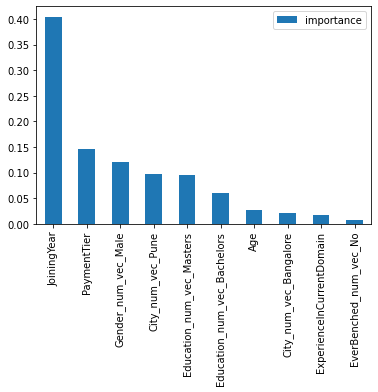

In [104]:
ax = feat_import[:20].plot(kind='bar')
ax.set_xticklabels(feat_import[:20]['feature'].tolist())

In [105]:
spark.stop()

## Conclusión

El mejor ajuste del modelo se ha obtenido utilizando _Random Forest_ .
Por otro lado, queda por explorar y mejorar el modelo utilizando ingeniería de atributos, sin dejar de observar la importancia de los atributos obtenidos en el gráfico que antecede; principalmente, con _'JoiningYear'_ y _'PaymentTipe'_ por ejemplo.  